# Final Model (Classwise/Y Scaling/Vt Feature/Drain Feature) with XGBoost

In [32]:
import torch
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from joblib import dump, load

In [33]:
W=35
L=8
T=25
test_df = pd.read_csv('./test_data/W35L8T25.csv')
test_df.head()

,Vds,Vgs,Ids,W,L,T
0,0.1,-20.0,2.628500e-13,35,8,25
1,0.1,-19.8,2.628500e-13,35,8,25
2,0.1,-19.6,2.628500e-13,35,8,25
3,0.1,-19.4,2.628500e-13,35,8,25
4,0.1,-19.2,2.628500e-13,35,8,25


In [34]:
vgs_list = test_df['Vgs'].unique()
len(vgs_list)
vds_list = test_df['Vds'].unique()
len(vds_list)

6

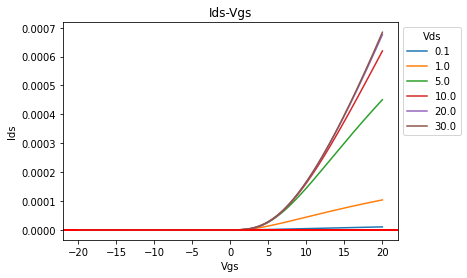

In [35]:
for vds in vds_list:
    plt.plot(test_df.query('Vds=='+str(vds))['Vgs'], test_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('Ids')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

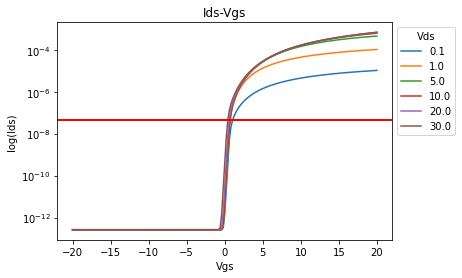

In [36]:
for vds in vds_list:
    plt.plot(test_df.query('Vds=='+str(vds))['Vgs'], test_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

In [37]:
vt_model = xgboost.XGBRegressor()
vt_model.load_model('./checkpoints/vt_xgboost.model')

In [38]:
test_df['Vt'] = test_df.apply(lambda row : vt_model.predict([row[['W','L', 'T','Vds']].to_numpy()])[0], axis=1)
test_df.head()

,Vds,Vgs,Ids,W,L,T,Vt
0,0.1,-20.0,2.628500e-13,35,8,25,0.999947
1,0.1,-19.8,2.628500e-13,35,8,25,0.999947
2,0.1,-19.6,2.628500e-13,35,8,25,0.999947
3,0.1,-19.4,2.628500e-13,35,8,25,0.999947
4,0.1,-19.2,2.628500e-13,35,8,25,0.999947


In [39]:
def calculate_drain_equation(width, length, vgs, vds, vt):
    right_term = (vgs-vt)*vds - 1/2*(vds**2)
    return (width/length)*right_term

In [40]:
test_df['Drain'] = test_df.apply(lambda row : calculate_drain_equation(row['W'], row['L'], row['Vgs'], row['Vds'], row['Vt']), axis=1)
test_df.head()

,Vds,Vgs,Ids,W,L,T,Vt,Drain
0,0.1,-20.0,2.628500e-13,35,8,25,0.999947,-9.209352
1,0.1,-19.8,2.628500e-13,35,8,25,0.999947,-9.121852
2,0.1,-19.6,2.628500e-13,35,8,25,0.999947,-9.034352
3,0.1,-19.4,2.628500e-13,35,8,25,0.999947,-8.946852
4,0.1,-19.2,2.628500e-13,35,8,25,0.999947,-8.859352


In [41]:
class_0_df = test_df.query('Vgs<0')
class_1_df = test_df.query('Vgs>=0')

In [42]:
class_0_model = xgboost.XGBRegressor()
class_0_model.load_model('./checkpoints/class_scale_vt_drain_xgboost_class_0.model')
class_1_model = xgboost.XGBRegressor()
class_1_model.load_model('./checkpoints/class_scale_vt_drain_xgboost_class_1.model')

In [43]:
class_0_X = class_0_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
scaler_0_X = load('./scalers/class_scale_vt_drain_xbgoost_class_0_std_scaler.bin')
class_0_X = scaler_0_X.transform(class_0_X)
class_0_y = class_0_df[['Ids']].to_numpy()

class_1_X = class_1_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
scaler_1_X = load('./scalers/class_scale_vt_drain_xbgoost_class_1_std_scaler.bin')
class_1_X = scaler_1_X.transform(class_1_X)
class_1_y = class_1_df[['Ids']].to_numpy()

In [44]:
def NRMSELoss(y_hat, y, eps=1e-8):
    log_abs_y_hat = np.log(np.abs(y_hat)+eps)
    log_abs_y = np.log(np.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = len(y_hat)
    return np.sqrt((1/len_delta)*np.sum((log_abs_delta/(log_abs_y+eps))**2)) + np.sqrt((1/len_delta)*np.sum((delta/(y+eps))**2))

In [45]:
def NRMSELoss_0(y_hat, y, eps=1e-8):
    log_abs_y_hat = np.log(np.abs(y_hat)+eps)
    log_abs_y = np.log(np.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = len(y_hat)
    return np.sqrt((1/len_delta)*np.sum((log_abs_delta/(log_abs_y+eps))**2))

In [46]:
def NRMSELoss_1(y_hat, y, eps=1e-8):
    log_abs_y_hat = np.log(np.abs(y_hat)+eps)
    log_abs_y = np.log(np.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = len(y_hat)
    return np.sqrt((1/len_delta)*np.sum((delta/(y+eps))**2))

In [47]:
class_0_pred = class_0_model.predict(class_0_X)
class_0_pred = np.exp(class_0_pred)
class_0_y = class_0_y.flatten()
class_0_nrmse_0 = NRMSELoss_0(class_0_pred, class_0_y)
class_0_nrmse_1 = NRMSELoss_1(class_0_pred, class_0_y)
class_0_nrmse = NRMSELoss(class_0_pred, class_0_y)
print(class_0_nrmse)
print(class_0_nrmse_0)
print(class_0_nrmse_1)

0.0016576257808226338
8.713612405696232e-05
0.0015704896567656716


In [48]:
class_1_pred = class_1_model.predict(class_1_X)
class_1_pred = np.exp(class_1_pred)
class_1_y = class_1_y.flatten()
class_1_nrmse_0 = NRMSELoss_0(class_1_pred, class_1_y)
class_1_nrmse_1 = NRMSELoss_1(class_1_pred, class_1_y)
class_1_nrmse = NRMSELoss(class_1_pred, class_1_y)
print(class_1_nrmse)
print(class_1_nrmse_0)
print(class_1_nrmse_1)

0.06723058772473275
0.00604131217590205
0.06118927554883071


In [49]:
total_pred = np.concatenate((class_0_pred, class_1_pred), axis=None)
total_y = np.concatenate((class_0_y, class_1_y), axis=None)
total_nrmse_0 = NRMSELoss_0(total_pred, total_y)
total_nrmse_1 = NRMSELoss_1(total_pred, total_y)
total_nrmse = NRMSELoss(total_pred, total_y)
print('Total NRMSE: ', total_nrmse)
print('NRMSE (Type0): ', total_nrmse_0)
print('NRMSE (Type1): ', total_nrmse_1)

Total NRMSE:  0.047435603372802684
NRMSE (Type0):  0.004261660704365603
NRMSE (Type1):  0.04317394266843708


In [50]:
class_0_df.insert(3, 'Pred_Ids', class_0_pred)
print(class_0_df)

       Vds           Vgs           Ids      Pred_Ids   W  L   T        Vt  \
0      0.1 -2.000000e+01  2.628500e-13  2.629331e-13  35  8  25  0.999947   
1      0.1 -1.980000e+01  2.628500e-13  2.629331e-13  35  8  25  0.999947   
2      0.1 -1.960000e+01  2.628500e-13  2.629331e-13  35  8  25  0.999947   
3      0.1 -1.940000e+01  2.628500e-13  2.629331e-13  35  8  25  0.999947   
4      0.1 -1.920000e+01  2.628500e-13  2.629331e-13  35  8  25  0.999947   
...    ...           ...           ...           ...  .. ..  ..       ...   
1101  30.0 -8.000000e-01  2.725500e-13  2.575132e-13  35  8  25  0.399937   
1102  30.0 -6.000000e-01  3.429300e-13  4.286425e-13  35  8  25  0.399937   
1103  30.0 -4.000000e-01  1.599400e-12  7.851947e-13  35  8  25  0.399937   
1104  30.0 -2.000000e-01  2.411900e-11  2.174233e-12  35  8  25  0.399937   
1105  30.0 -3.758100e-14  4.243700e-10  2.217379e-11  35  8  25  0.399937   

            Drain  
0       -9.209352  
1       -9.121852  
2       -9.0343

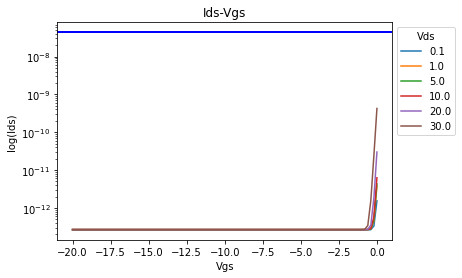

In [51]:
vgs_list = class_0_df['Vgs'].unique()
len(vgs_list)
vds_list = class_0_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_0_df.query('Vds=='+str(vds))['Vgs'], class_0_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

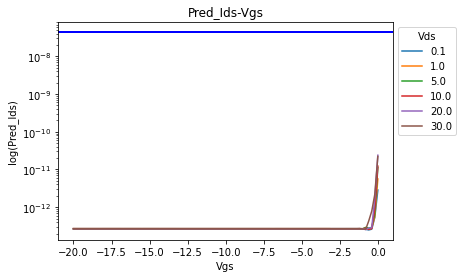

In [52]:
vgs_list = class_0_df['Vgs'].unique()
len(vgs_list)
vds_list = class_0_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_0_df.query('Vds=='+str(vds))['Vgs'], class_0_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Pred_Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Pred_Ids-Vgs')

In [53]:
class_1_df.insert(3, 'Pred_Ids', class_1_pred)
print(class_1_df)

       Vds   Vgs           Ids      Pred_Ids   W  L   T        Vt       Drain
101    0.1   0.2  2.349200e-11  3.549043e-11  35  8  25  0.999947   -0.371852
102    0.1   0.4  4.073900e-10  3.641019e-10  35  8  25  0.999947   -0.284352
103    0.1   0.6  4.861400e-09  3.507967e-09  35  8  25  0.999947   -0.196852
104    0.1   0.8  1.962100e-08  1.700502e-08  35  8  25  0.999947   -0.109352
105    0.1   1.0  4.056000e-08  3.479023e-08  35  8  25  0.999947   -0.021852
...    ...   ...           ...           ...  .. ..  ..       ...         ...
1201  30.0  19.2  6.359800e-04  6.750479e-04  35  8  25  0.399937  498.758292
1202  30.0  19.4  6.479800e-04  6.727243e-04  35  8  25  0.399937  525.008292
1203  30.0  19.6  6.600400e-04  6.916974e-04  35  8  25  0.399937  551.258292
1204  30.0  19.8  6.721500e-04  6.988638e-04  35  8  25  0.399937  577.508292
1205  30.0  20.0  6.843100e-04  6.932467e-04  35  8  25  0.399937  603.758292

[600 rows x 9 columns]


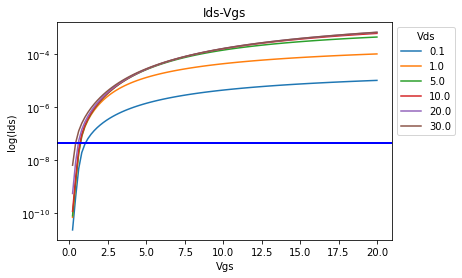

In [54]:
vgs_list = class_1_df['Vgs'].unique()
len(vgs_list)
vds_list = class_1_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_1_df.query('Vds=='+str(vds))['Vgs'], class_1_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

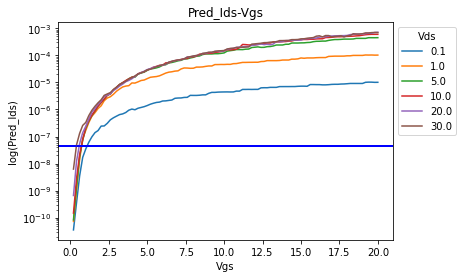

In [55]:
vgs_list = class_1_df['Vgs'].unique()
len(vgs_list)
vds_list = class_1_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_1_df.query('Vds=='+str(vds))['Vgs'], class_1_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Pred_Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Pred_Ids-Vgs')

In [56]:
merged_df = pd.concat([class_0_df, class_1_df])
print(merged_df)

       Vds   Vgs           Ids      Pred_Ids   W  L   T        Vt       Drain
0      0.1 -20.0  2.628500e-13  2.629331e-13  35  8  25  0.999947   -9.209352
1      0.1 -19.8  2.628500e-13  2.629331e-13  35  8  25  0.999947   -9.121852
2      0.1 -19.6  2.628500e-13  2.629331e-13  35  8  25  0.999947   -9.034352
3      0.1 -19.4  2.628500e-13  2.629331e-13  35  8  25  0.999947   -8.946852
4      0.1 -19.2  2.628500e-13  2.629331e-13  35  8  25  0.999947   -8.859352
...    ...   ...           ...           ...  .. ..  ..       ...         ...
1201  30.0  19.2  6.359800e-04  6.750479e-04  35  8  25  0.399937  498.758292
1202  30.0  19.4  6.479800e-04  6.727243e-04  35  8  25  0.399937  525.008292
1203  30.0  19.6  6.600400e-04  6.916974e-04  35  8  25  0.399937  551.258292
1204  30.0  19.8  6.721500e-04  6.988638e-04  35  8  25  0.399937  577.508292
1205  30.0  20.0  6.843100e-04  6.932467e-04  35  8  25  0.399937  603.758292

[1206 rows x 9 columns]


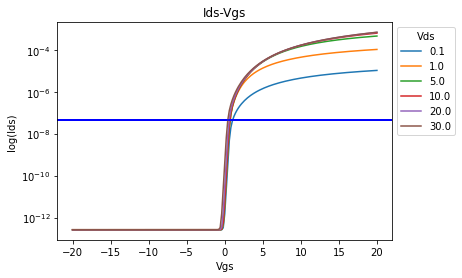

In [57]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(merged_df.query('Vds=='+str(vds))['Vgs'], merged_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

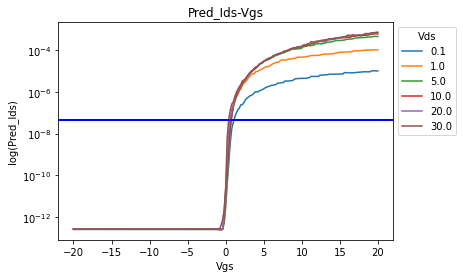

In [58]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(merged_df.query('Vds=='+str(vds))['Vgs'], merged_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Pred_Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Pred_Ids-Vgs')

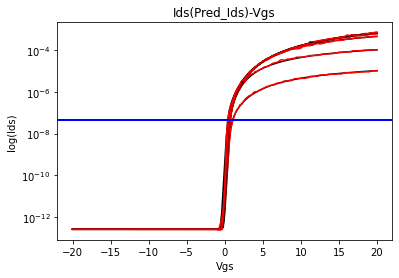

In [59]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(merged_df.query('Vds=='+str(vds))['Vgs'], merged_df.query('Vds=='+str(vds))['Ids'], label=vds, color='black')
    plt.plot(merged_df.query('Vds=='+str(vds))['Vgs'], merged_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds, color='red')
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    # plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids(Pred_Ids)-Vgs')

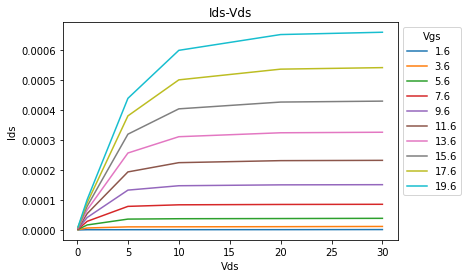

In [60]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
vgs_list = [(i+1.6) for i in range(0, 20, 2)]
for vgs in vgs_list:
    plt.plot(merged_df.query('Vgs=='+str(vgs))['Vds'], merged_df.query('Vgs=='+str(vgs))['Ids'], label=vgs)
    plt.xlabel('Vds')
    plt.ylabel('Ids')
    # plt.yscale('log')
    # plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vgs')
    plt.title('Ids-Vds')

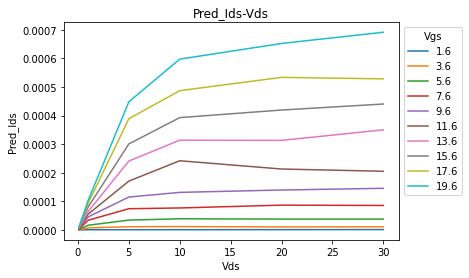

In [61]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
vgs_list = [(i+1.6) for i in range(0, 20, 2)]
for vgs in vgs_list:
    plt.plot(merged_df.query('Vgs=='+str(vgs))['Vds'], merged_df.query('Vgs=='+str(vgs))['Pred_Ids'], label=vgs)
    plt.xlabel('Vds')
    plt.ylabel('Pred_Ids')
    # plt.yscale('log')
    # plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vgs')
    plt.title('Pred_Ids-Vds')

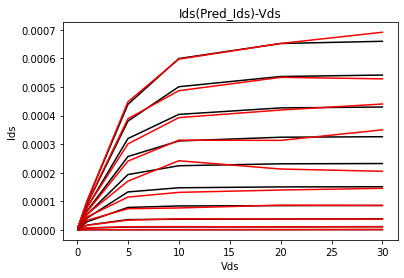

In [62]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
vgs_list = [(i+1.6) for i in range(0, 20, 2)]
for vgs in vgs_list:
    plt.plot(merged_df.query('Vgs=='+str(vgs))['Vds'], merged_df.query('Vgs=='+str(vgs))['Ids'], label=vgs, color='black')
    plt.plot(merged_df.query('Vgs=='+str(vgs))['Vds'], merged_df.query('Vgs=='+str(vgs))['Pred_Ids'], label=vgs, color='red')
    plt.xlabel('Vds')
    plt.ylabel('Ids')
    # plt.yscale('log')
    # plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    # plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vgs')
    plt.title('Ids(Pred_Ids)-Vds')